# Fiscal Policy plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import json

import sim_steady_state_fast as sim 

In [2]:
plt.rcParams.update({'font.size': 10, 'font.family': 'serif', 'figure.figsize': (6, 3)})
plt.rcParams.update({'text.usetex': True, 'font.serif': 'Palatino'})

In [3]:
import sequence_jacobian as sj
from household import hh, calibration

In [4]:
# Compute steady state
ss = hh.steady_state(calibration)

In [5]:
# time horizon used here
T = 400

## Plotting iMPCs

### Het agent

In [6]:
# compute Jacobian
J = hh.jacobian(ss, inputs=['Z'], outputs=['C', 'A'], T=400)
M, A = J['C', 'Z'], J['A', 'Z']

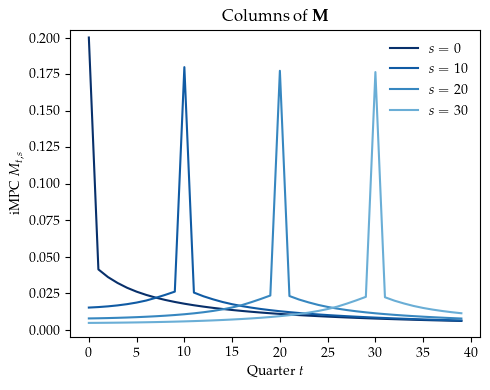

In [7]:
plt.figure(figsize=(5, 4))
# add colors that are shades of blue, going from dark to light
colors = plt.cm.Blues(np.linspace(0.5, 1, 4)[::-1])
for i, s in enumerate([0, 10, 20, 30]):
    plt.plot(M[:40, s], label=f'$s={s}$', color=colors[i])
plt.xlabel('Quarter $t$')
plt.ylabel('iMPC $M_{t,s}$')
plt.title('Columns of $\mathbf{M}$')
plt.legend(frameon=False)
plt.tight_layout()
plt.ylim(-0.005, 0.205)
plt.savefig('figures/fiscal_impc.pdf', transparent=True, bbox_inches='tight')


### Rep agent

In [8]:
q = (1 + ss['r']) ** -np.arange(T)
M_ra = np.outer(np.ones(T), q) / np.sum(q)

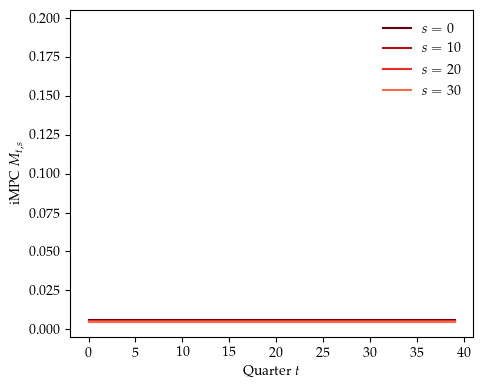

In [9]:
plt.figure(figsize=(5, 4))
# add colors that are shades of blue, going from dark to light
colors = plt.cm.Reds(np.linspace(0.5, 1, 4)[::-1])
for i, s in enumerate([0, 10, 20, 30]):
    plt.plot(M_ra[:40, s], label=f'$s={s}$', color=colors[i])
plt.xlabel('Quarter $t$')
plt.ylabel('iMPC $M_{t,s}$')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('figures/fiscal_impc_ra.pdf', transparent=True, bbox_inches='tight')
plt.ylim(-0.005, 0.205)
plt.savefig('figures/fiscal_impc_ra_zoomedout.pdf', transparent=True, bbox_inches='tight')

### Two agent

In [10]:
# get share of HTM to hit MPC
lam = (0.20 - M_ra[0, 0]) / (1 - M_ra[0, 0])
M_ta = lam * np.eye(T) + (1 - lam) * M_ra

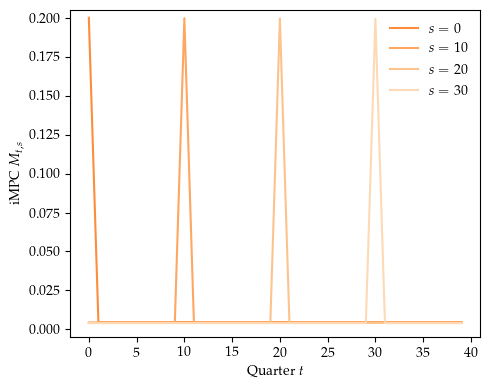

In [11]:
plt.figure(figsize=(5, 4))
# add colors that are shades of blue, going from dark to light
colors = plt.cm.Oranges(np.linspace(0.2, 0.5, 4)[::-1])
for i, s in enumerate([0, 10, 20, 30]):
    plt.plot(M_ta[:40, s], label=f'$s={s}$', color=colors[i])
plt.xlabel('Quarter $t$')
plt.ylabel('iMPC $M_{t,s}$')
plt.legend(frameon=False)
plt.tight_layout()
plt.ylim(-0.005, 0.205)
plt.savefig('figures/fiscal_impc_ta_zoomedout.pdf', transparent=True, bbox_inches='tight')

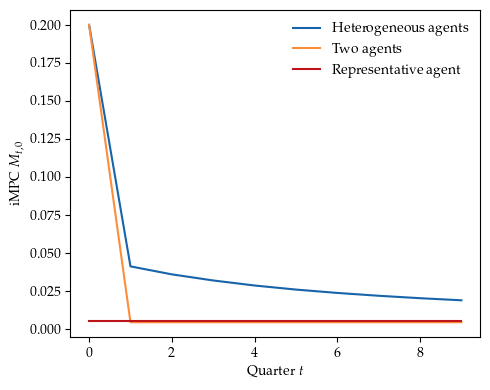

In [12]:
# Compare the first columns of each
plt.figure(figsize=(5, 4))
plt.plot(M[:10, 0], label='Heterogeneous agents', color=plt.cm.Blues(0.8))
plt.plot(M_ta[:10, 0], label='Two agents', color=plt.cm.Oranges(0.5))
plt.plot(M_ra[:10, 0], label='Representative agent', color=plt.cm.Reds(0.8))
plt.xlabel('Quarter $t$')
plt.ylabel('iMPC $M_{t,0}$')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('figures/fiscal_impc_comparison.pdf', transparent=True, bbox_inches='tight')


## Tax cut

In [13]:
rho_B, rho = 0.975, 0.9

dT_shock = -rho**np.arange(T)
dB = np.empty_like(dT_shock)
dB[0] = -dT_shock[0]
for t in range(1, T):
    dB[t] = rho_B * dB[t-1] - dT_shock[t]

# back out actual dT path (not the pure shock)
dT = np.empty_like(dT_shock)
dT[0] = - dB[0]
dT[1:] = - dB[1:] + dB[:-1] * (1 + ss['r'])  # tax cut shock, financed by debt

# assert dT has zero NPV
print("NPV of tax cut shock:", np.sum(dT * (1 + ss['r']) ** (-np.arange(T))))

NPV of tax cut shock: -7.286624256169771e-05


Plot dT and then dB

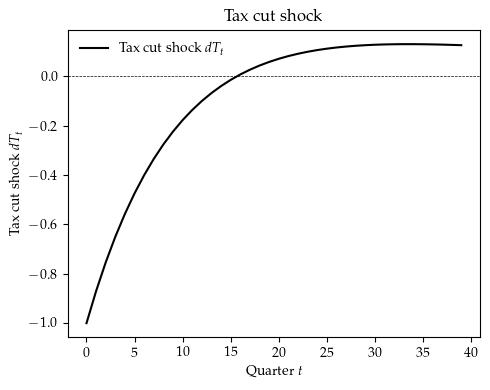

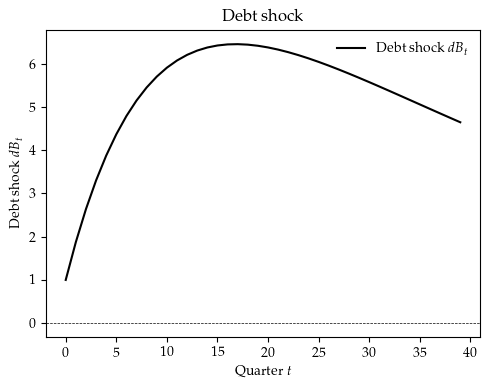

In [14]:
plt.figure(figsize=(5, 4))
plt.plot(dT[:40], label='Tax cut shock $d T_t$', color='k')
# add dashed line at zero
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.xlabel('Quarter $t$')
plt.ylabel('Tax cut shock $d T_t$')
plt.title('Tax cut shock')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('figures/fiscal_tax_cut_shock.pdf', transparent=True, bbox_inches='tight')

plt.figure(figsize=(5, 4))
plt.plot(dB[:40], label='Debt shock $d B_t$', color='k')
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.xlabel('Quarter $t$')
plt.ylabel('Debt shock $d B_t$')
plt.title('Debt shock')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('figures/fiscal_debt_shock.pdf', transparent=True, bbox_inches='tight')


In [15]:
# Compute output responses
dY = {'ra': np.zeros(T), 'ta': lam/(1 - lam) * (-dT), 'ha': np.linalg.solve(A, dB) + dT}

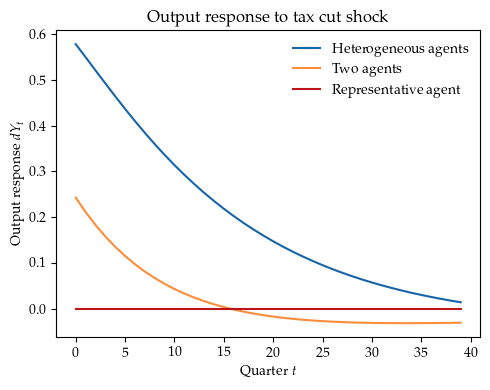

In [16]:
# Plot responses
plt.figure(figsize=(5, 4))
# make colors a nice red for RA, orange for TA, blue for HA, SAME dark colors from before
plt.plot(dY['ha'][:40], label='Heterogeneous agents', color=plt.cm.Blues(0.8))
plt.plot(dY['ta'][:40], label='Two agents', color=plt.cm.Oranges(0.5))
plt.plot(dY['ra'][:40], label='Representative agent', color=plt.cm.Reds(0.8))
plt.xlabel('Quarter $t$')
plt.ylabel('Output response $d Y_t$')
plt.title('Output response to tax cut shock')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('figures/fiscal_output_response.pdf', transparent=True, bbox_inches='tight')